In [1]:
# Anthony Townsend, 2018 March
# House Price Predictor
# Based on NJ 2013-2017 SR1A Sales Records

In [2]:
# references
# https://www.kaggle.com/erick5/predicting-house-prices-with-machine-learning

In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 1000
import matplotlib.pyplot as plt
import warnings
# import xgboost as xgb
# import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
# from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [4]:
# import data
sales09 = pd.read_csv("Sales09.csv", low_memory=False)
sales10 = pd.read_csv("Sales10.csv", low_memory=False)
sales11 = pd.read_csv("Sales11.csv", low_memory=False)
sales12 = pd.read_csv("Sales12.csv", low_memory=False)
sales13 = pd.read_csv("Sales13.csv", low_memory=False)
sales14 = pd.read_csv("Sales14.csv", low_memory=False)
sales15 = pd.read_csv("Sales15.csv", low_memory=False)
sales16 = pd.read_csv("Sales16.csv", low_memory=False)
sales17 = pd.read_csv("Sales17.csv", low_memory=False)


In [5]:
# add a column to each table indicating the year of the file
sales09.insert(0, 'year_sale', 2009)
sales10.insert(0, 'year_sale', 2010)
sales11.insert(0, 'year_sale', 2011)
sales12.insert(0, 'year_sale', 2012)
sales13.insert(0, 'year_sale', 2013)
sales14.insert(0, 'year_sale', 2014)
sales15.insert(0, 'year_sale', 2015)
sales16.insert(0, 'year_sale', 2016)
sales17.insert(0, 'year_sale', 2017)

In [6]:
years=[sales09, sales10, sales11, sales12, sales13, sales14, sales15, sales16, sales17]
sales = pd.concat(years)

In [7]:
sales.head()

,year_sale,pams_pin,county_code,district_code,batch_number,dln,operator_initials,last_update_date,questionnaire_status_code,questionnaire_date,...,date_typed,assessor_nu_code,field_status_code,field_date,critical_error_flag,condo,appeal_status,assessor_written_cd,year_built,living_space
0,2009,0601_13_36,6,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,5,0,NaN,NaN,NaN,Y,1,9260,1263
1,2009,0601_13_37,6,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,5,0,NaN,NaN,NaN,Y,1,9350,908
2,2009,0601_37_10,6,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,NaN,NaN,Y,1,9300,1176
3,2009,0601_45_20,6,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,3,0,NaN,NaN,NaN,Y,1,9000,1230
4,2009,0601_51_17,6,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,4,0,NaN,NaN,NaN,Y,1,9000,1845


In [9]:
# pick out hudson county

sales_hudsoncty = sales[sales.county_code == 9]

In [10]:
sales_hudsoncty.head()

,year_sale,pams_pin,county_code,district_code,batch_number,dln,operator_initials,last_update_date,questionnaire_status_code,questionnaire_date,...,date_typed,assessor_nu_code,field_status_code,field_date,critical_error_flag,condo,appeal_status,assessor_written_cd,year_built,living_space
870,2009,0901_15_6,9,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,5,0,NaN,NaN,NaN,Y,1,9300,1402
871,2009,0901_15_19,9,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,NaN,NaN,Y,1,9300,960
872,2009,0901_24_1.501,9,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,5,0,NaN,Y,NaN,Y,1,9600,800
873,2009,0901_24_1.710,9,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,Y,NaN,Y,1,9600,675
874,2009,0901_29_18,9,1,99999,9030809,NaN,NaN,NaN,NaN,...,NaN,5,0,NaN,NaN,NaN,Y,1,9200,2172


In [11]:
sales_hudsoncty.describe()

,year_sale,county_code,district_code,batch_number,dln,questionnaire_status_code,questionnaire_date,reported_sales_price,verified_sales_price,assessed_value_land,...,addl_value_land4,addl_value_bldg4,addl_value_total4,addl_value_land5,addl_value_bldg5,addl_value_total5,assess_year,class_4_type,year_built,living_space
count,83114.000000,83114.0,83114.000000,83114.0,8.311400e+04,0.0,0.0,8.311400e+04,8.311400e+04,8.311400e+04,...,8.311400e+04,83114.000000,8.311400e+04,8.311400e+04,8.311400e+04,8.311400e+04,83114.000000,83114.000000,83114.000000,83114.000000
mean,2013.308432,9.0,6.301899,99999.0,4.376629e+06,NaN,NaN,3.972716e+05,3.962326e+05,1.332062e+05,...,9.027103e+01,49.424598,1.393948e+02,9.536543e+01,5.959812e+01,1.538939e+02,12.689114,23.321414,2097.458876,1043.616527
std,2.655813,0.0,2.561103,0.0,2.722662e+06,NaN,NaN,2.663274e+06,2.661049e+06,1.455592e+06,...,7.438783e+03,3579.177694,9.279679e+03,1.091126e+04,5.706380e+03,1.426231e+04,2.948501,116.044191,3095.437806,1497.611279
min,2009.000000,9.0,1.000000,99999.0,3.091000e+04,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,9.0,5.000000,99999.0,2.031204e+06,NaN,NaN,1.000000e+02,1.000000e+02,1.000000e+04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.000000,0.000000,0.000000,0.000000
50%,2014.000000,9.0,6.000000,99999.0,4.031407e+06,NaN,NaN,2.400000e+05,2.400000e+05,2.500000e+04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,13.000000,0.000000,1891.000000,837.000000
75%,2016.000000,9.0,8.000000,99999.0,6.031608e+06,NaN,NaN,4.500000e+05,4.500000e+05,6.720000e+04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,15.000000,0.000000,1998.000000,1512.000000
max,2017.000000,9.0,12.000000,99999.0,9.030909e+06,NaN,NaN,3.775000e+08,3.775000e+08,4.914000e+07,...,1.387500e+06,660800.000000,1.653200e+06,2.300000e+06,1.350000e+06,2.450000e+06,99.000000,990.000000,9990.000000,32570.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104627190>]], dtype=object)

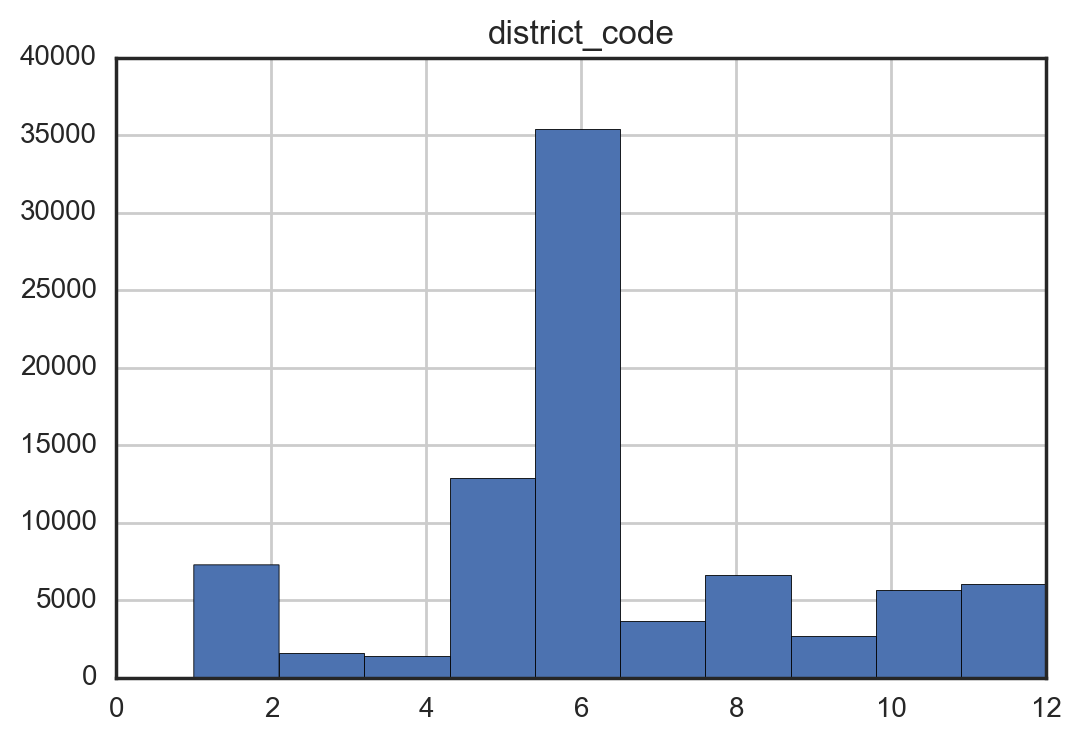

In [12]:
sales_hudsoncty.hist(column='district_code')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117efb290>]], dtype=object)

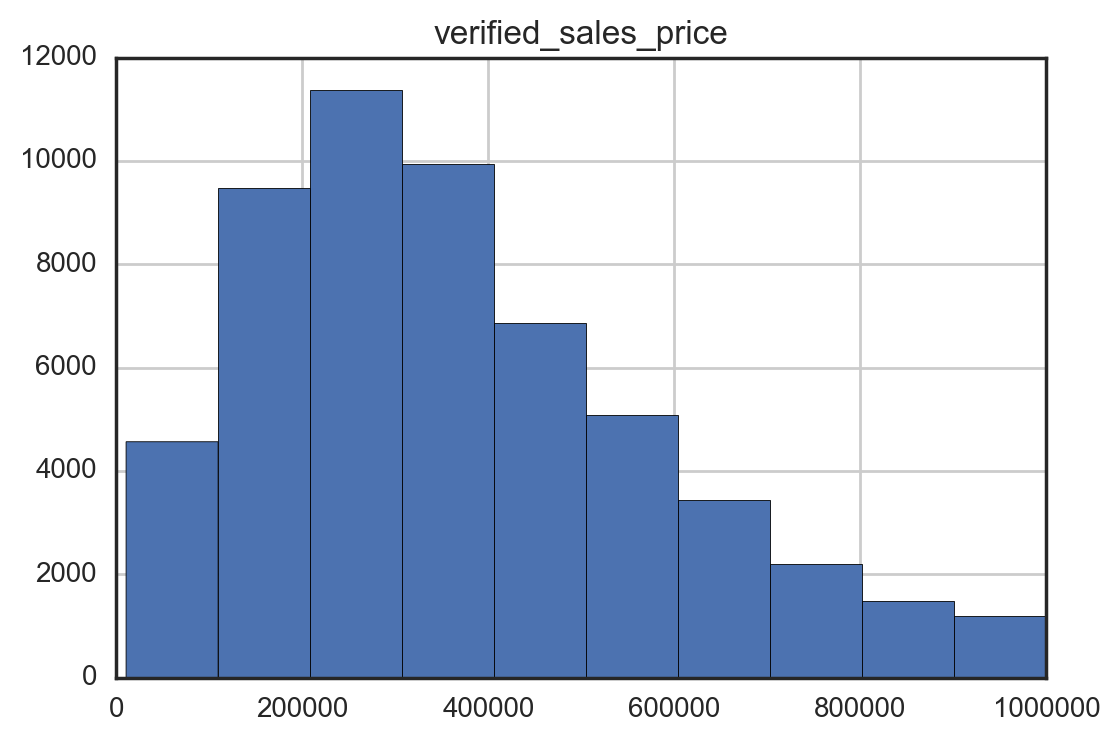

In [14]:
sales_hudsoncty_1 = sales_hudsoncty.loc[sales_hudsoncty['verified_sales_price']
 < 1000000]

sales_hudsoncty_1m = sales_hudsoncty_1.loc[sales_hudsoncty_1['verified_sales_price']
 > 10000]


sales_hudsoncty_1m.hist(column='verified_sales_price')

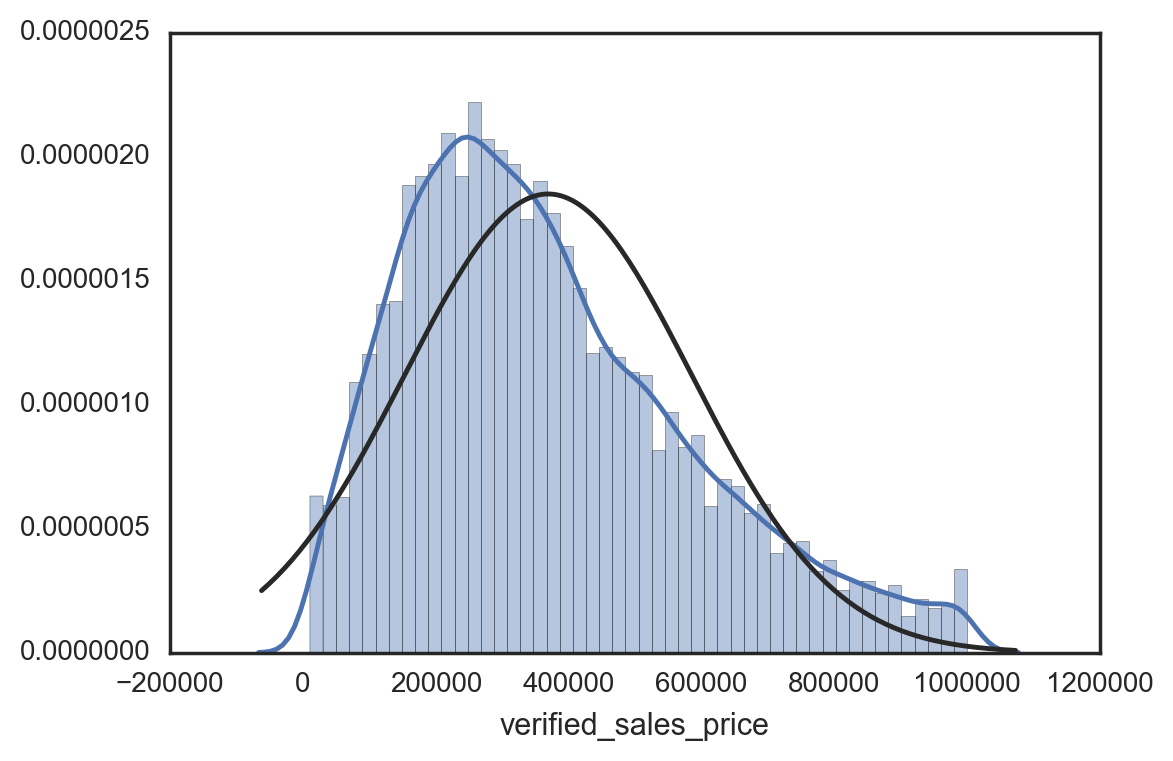

In [15]:
sns.distplot(sales_hudsoncty_1m['verified_sales_price'], fit=norm);

In [16]:
# pick out the 35,388 properties in Jersey City that changed hands 2009-2017

sales_jerseycity = sales[(sales.county_code == 9 ) & (sales.district_code == 6)]


In [17]:
sales_jerseycity.head()

,year_sale,pams_pin,county_code,district_code,batch_number,dln,operator_initials,last_update_date,questionnaire_status_code,questionnaire_date,...,date_typed,assessor_nu_code,field_status_code,field_date,critical_error_flag,condo,appeal_status,assessor_written_cd,year_built,living_space
1087,2009,0906_15_31_C1003,9,6,99999,9030809,JTB,2008-10-08,NaN,NaN,...,NaN,6 R,0,NaN,Y,NaN,Y,2,0,1104
1088,2009,0906_15_31_C1504,9,6,99999,9030809,JTB,2008-10-08,NaN,NaN,...,NaN,6 R,0,NaN,Y,NaN,Y,2,0,1173
1089,2009,0906_15_31_C1611,9,6,99999,9030809,JTB,2008-10-08,NaN,NaN,...,NaN,6 R,0,NaN,Y,NaN,Y,2,0,697
1090,2009,0906_15_31_C1709,9,6,99999,9030809,JTB,2008-10-08,NaN,NaN,...,NaN,6 R,0,NaN,Y,NaN,Y,2,0,1173
1091,2009,0906_15_31_C1904,9,6,99999,9030809,JTB,2008-10-08,NaN,NaN,...,NaN,6 R,0,NaN,Y,NaN,Y,2,0,1173


In [19]:
sales_jerseycity.describe()

,year_sale,county_code,district_code,batch_number,dln,questionnaire_status_code,questionnaire_date,reported_sales_price,verified_sales_price,assessed_value_land,...,addl_value_land4,addl_value_bldg4,addl_value_total4,addl_value_land5,addl_value_bldg5,addl_value_total5,assess_year,class_4_type,year_built,living_space
count,35388.000000,35388.0,35388.0,35388.0,3.538800e+04,0.0,0.0,3.538800e+04,3.538800e+04,3.538800e+04,...,3.538800e+04,35388.000000,3.538800e+04,3.538800e+04,35388.000000,3.538800e+04,35388.000000,35388.000000,35388.000000,35388.000000
mean,2013.328021,9.0,6.0,99999.0,4.400655e+06,NaN,NaN,3.857657e+05,3.857447e+05,4.305855e+04,...,7.671770e+01,29.054369,1.050656e+02,1.366029e+02,26.521363,1.606121e+02,12.706115,5.988951,1137.687239,608.396038
std,2.660638,0.0,0.0,0.0,2.719314e+06,NaN,NaN,3.471985e+06,3.472371e+06,2.372433e+05,...,7.683390e+03,1492.135269,7.980272e+03,1.515169e+04,1669.703443,1.534784e+04,2.942913,63.975945,2378.936055,1048.149973
min,2009.000000,9.0,6.0,99999.0,3.091000e+04,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,9.0,6.0,99999.0,2.031206e+06,NaN,NaN,1.000000e+02,1.000000e+02,5.600000e+03,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,10.000000,0.000000,0.000000,0.000000
50%,2014.000000,9.0,6.0,99999.0,4.031407e+06,NaN,NaN,2.200000e+05,2.200000e+05,1.040000e+04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,13.000000,0.000000,0.000000,0.000000
75%,2016.000000,9.0,6.0,99999.0,7.031610e+06,NaN,NaN,4.350000e+05,4.350000e+05,2.000000e+04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,15.000000,0.000000,1900.000000,1008.000000
max,2017.000000,9.0,6.0,99999.0,9.030908e+06,NaN,NaN,3.775000e+08,3.775000e+08,1.306840e+07,...,1.362600e+06,151300.000000,1.378500e+06,2.300000e+06,200000.000000,2.300000e+06,99.000000,959.000000,9990.000000,32570.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118ccf8d0>]], dtype=object)

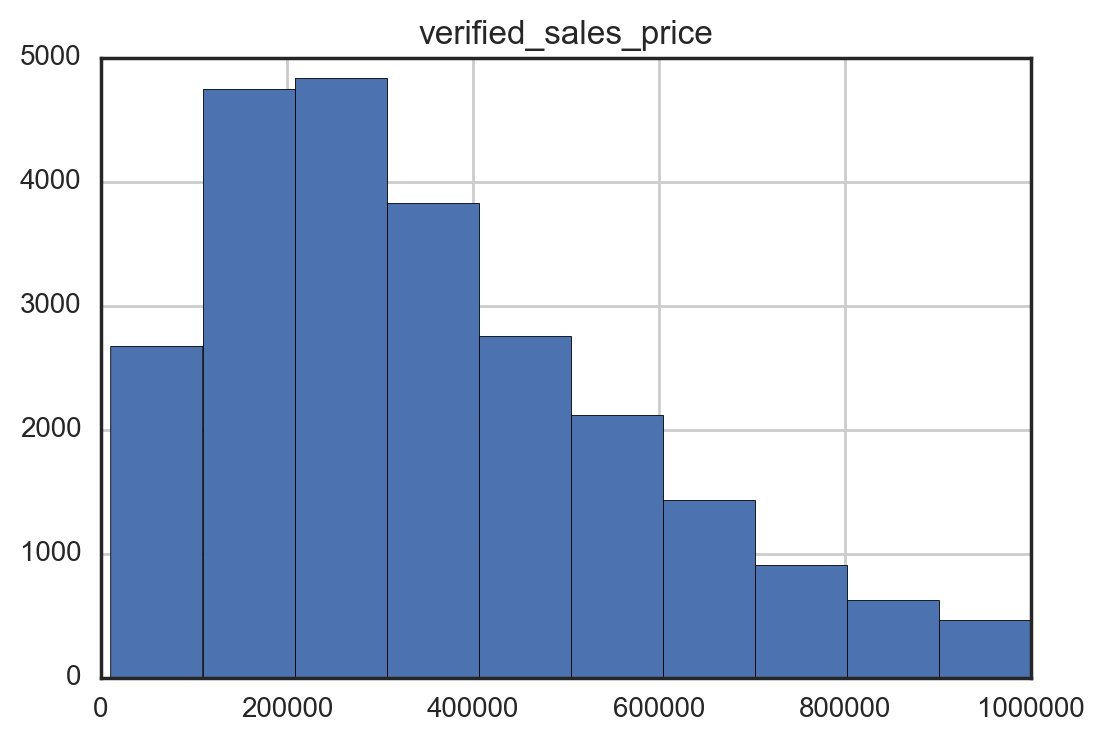

In [20]:
sales_jerseycity_1 = sales_jerseycity.loc[sales_jerseycity['verified_sales_price']
 < 1000000]

sales_jerseycity_1m = sales_jerseycity_1.loc[sales_jerseycity_1['verified_sales_price']
 > 10000]


sales_jerseycity_1m.hist(column='verified_sales_price')

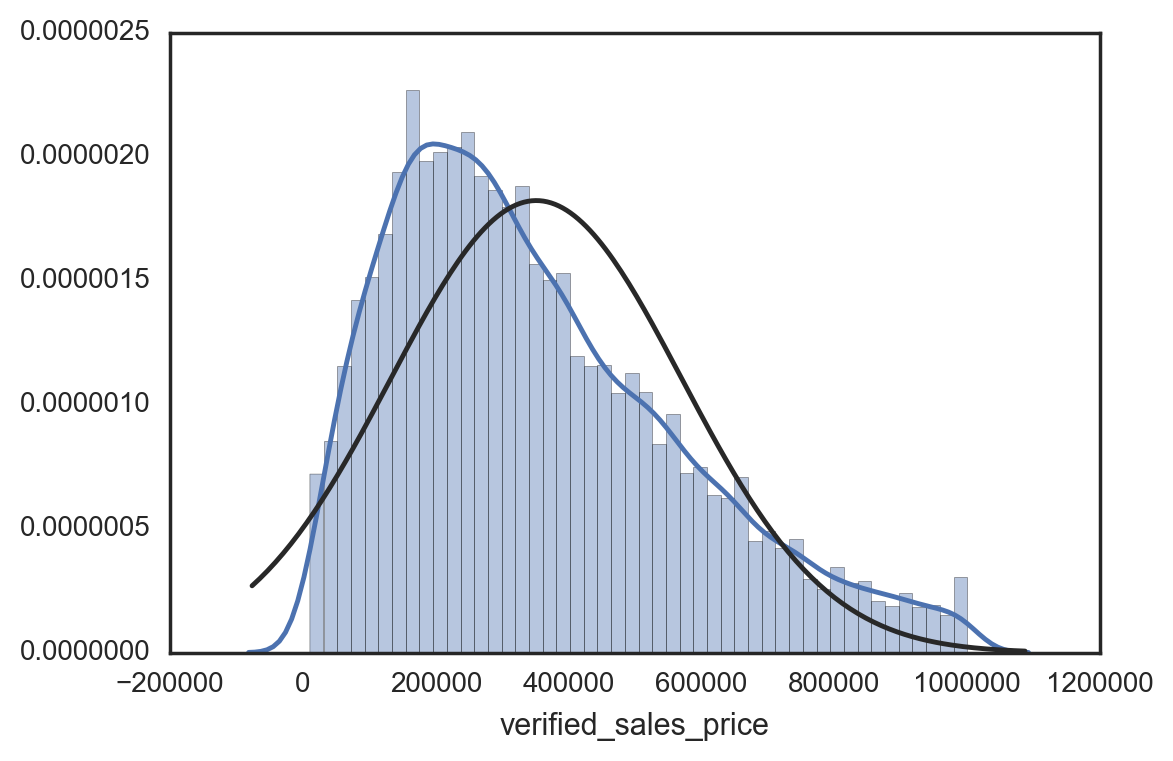

In [21]:
# for all years, 2008-2017

sns.distplot(sales_jerseycity_1m['verified_sales_price'], fit=norm);

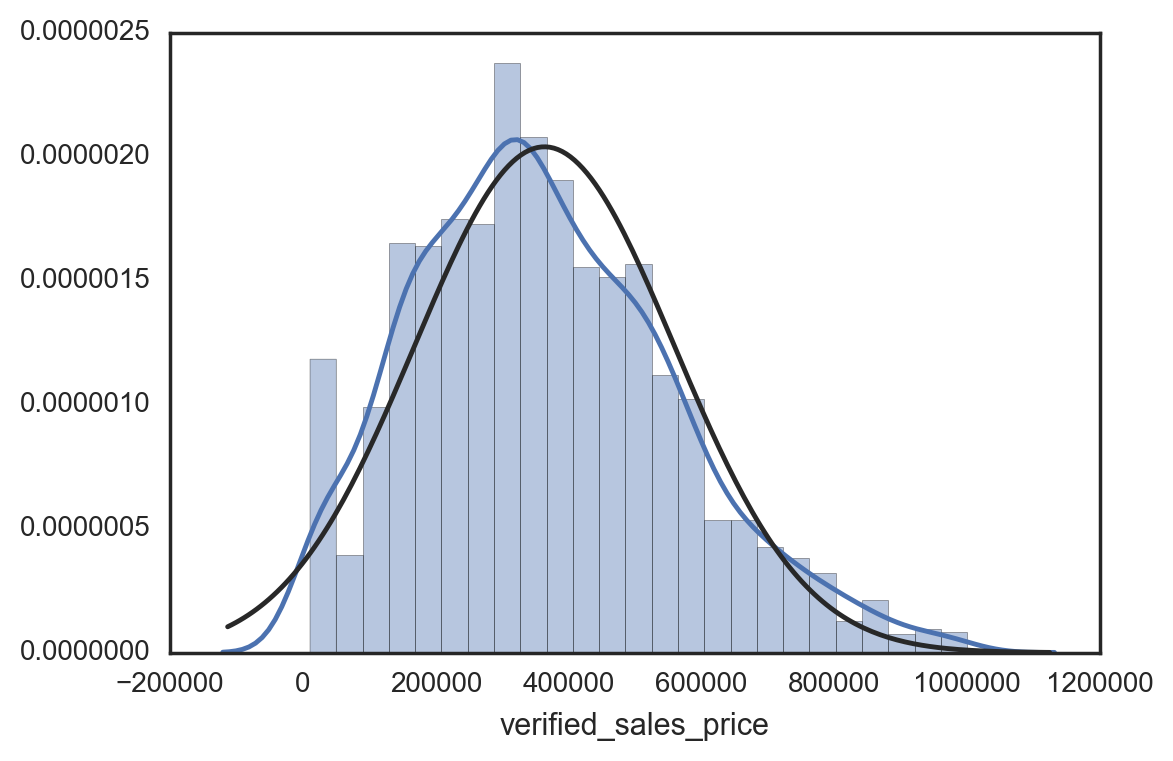

In [24]:
# 2009
sales_jerseycity_1m_2009 = sales_jerseycity_1m[sales_jerseycity_1m.year_sale == 2009]
sns.distplot(sales_jerseycity_1m_2009['verified_sales_price'], fit=norm);


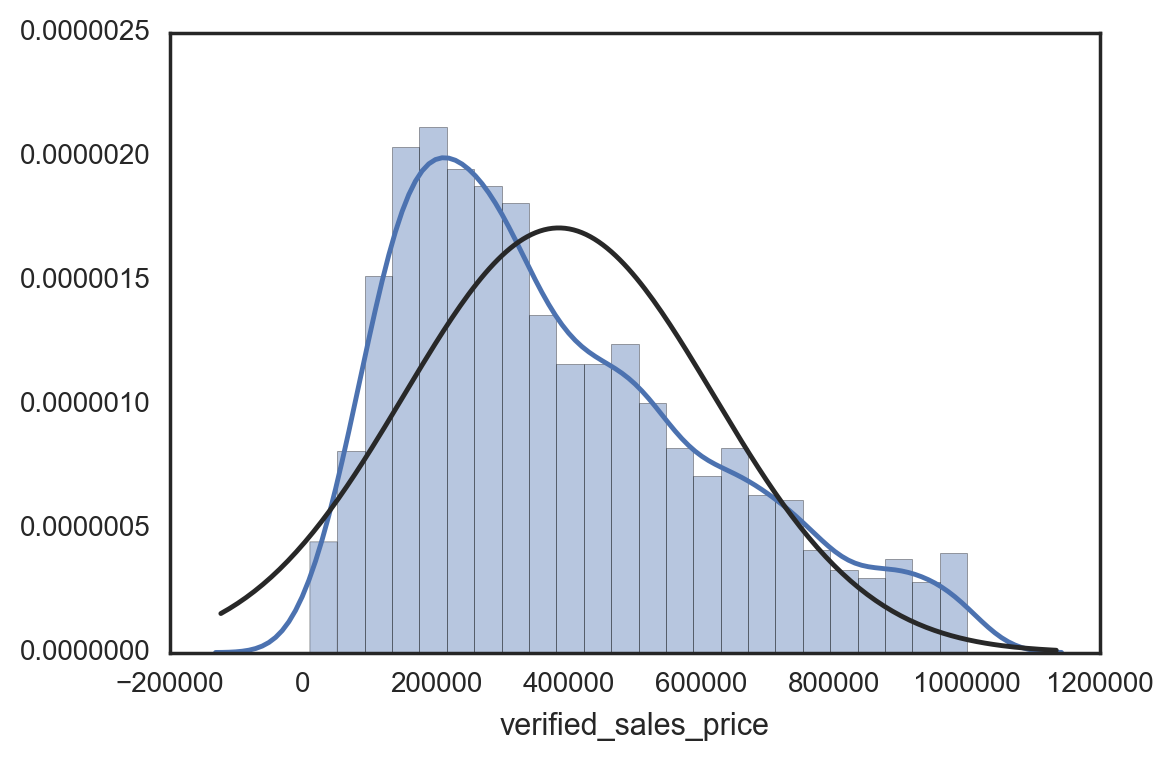

In [23]:
# 2017
sales_jerseycity_1m_2017 = sales_jerseycity_1m[sales_jerseycity_1m.year_sale == 2017]
sns.distplot(sales_jerseycity_1m_2017['verified_sales_price'], fit=norm);


In [ ]:
# next step would be to try to scrape some information about the addresses / block and lot and staert building the model against that?

# because it doesnt seem that any of the data in this really correlate / predict the sale price